In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

data_base_name = "p"

In [2]:
   
data_filename = f"data\{data_base_name}.csv"
print(f'read {data_filename}')

columns = ['_time','pressure_1','pressure_2','temperature_1','temperature_2','velocity_1','velocity_2']

frame = pd.read_csv(data_filename, skiprows=[0,1,2], usecols=columns)
frame['_time'] = pd.to_datetime(frame['_time'], format="ISO8601")

series_name = "pressure_1"
   
times = frame["_time"]
series = frame[series_name]


read data\p.csv


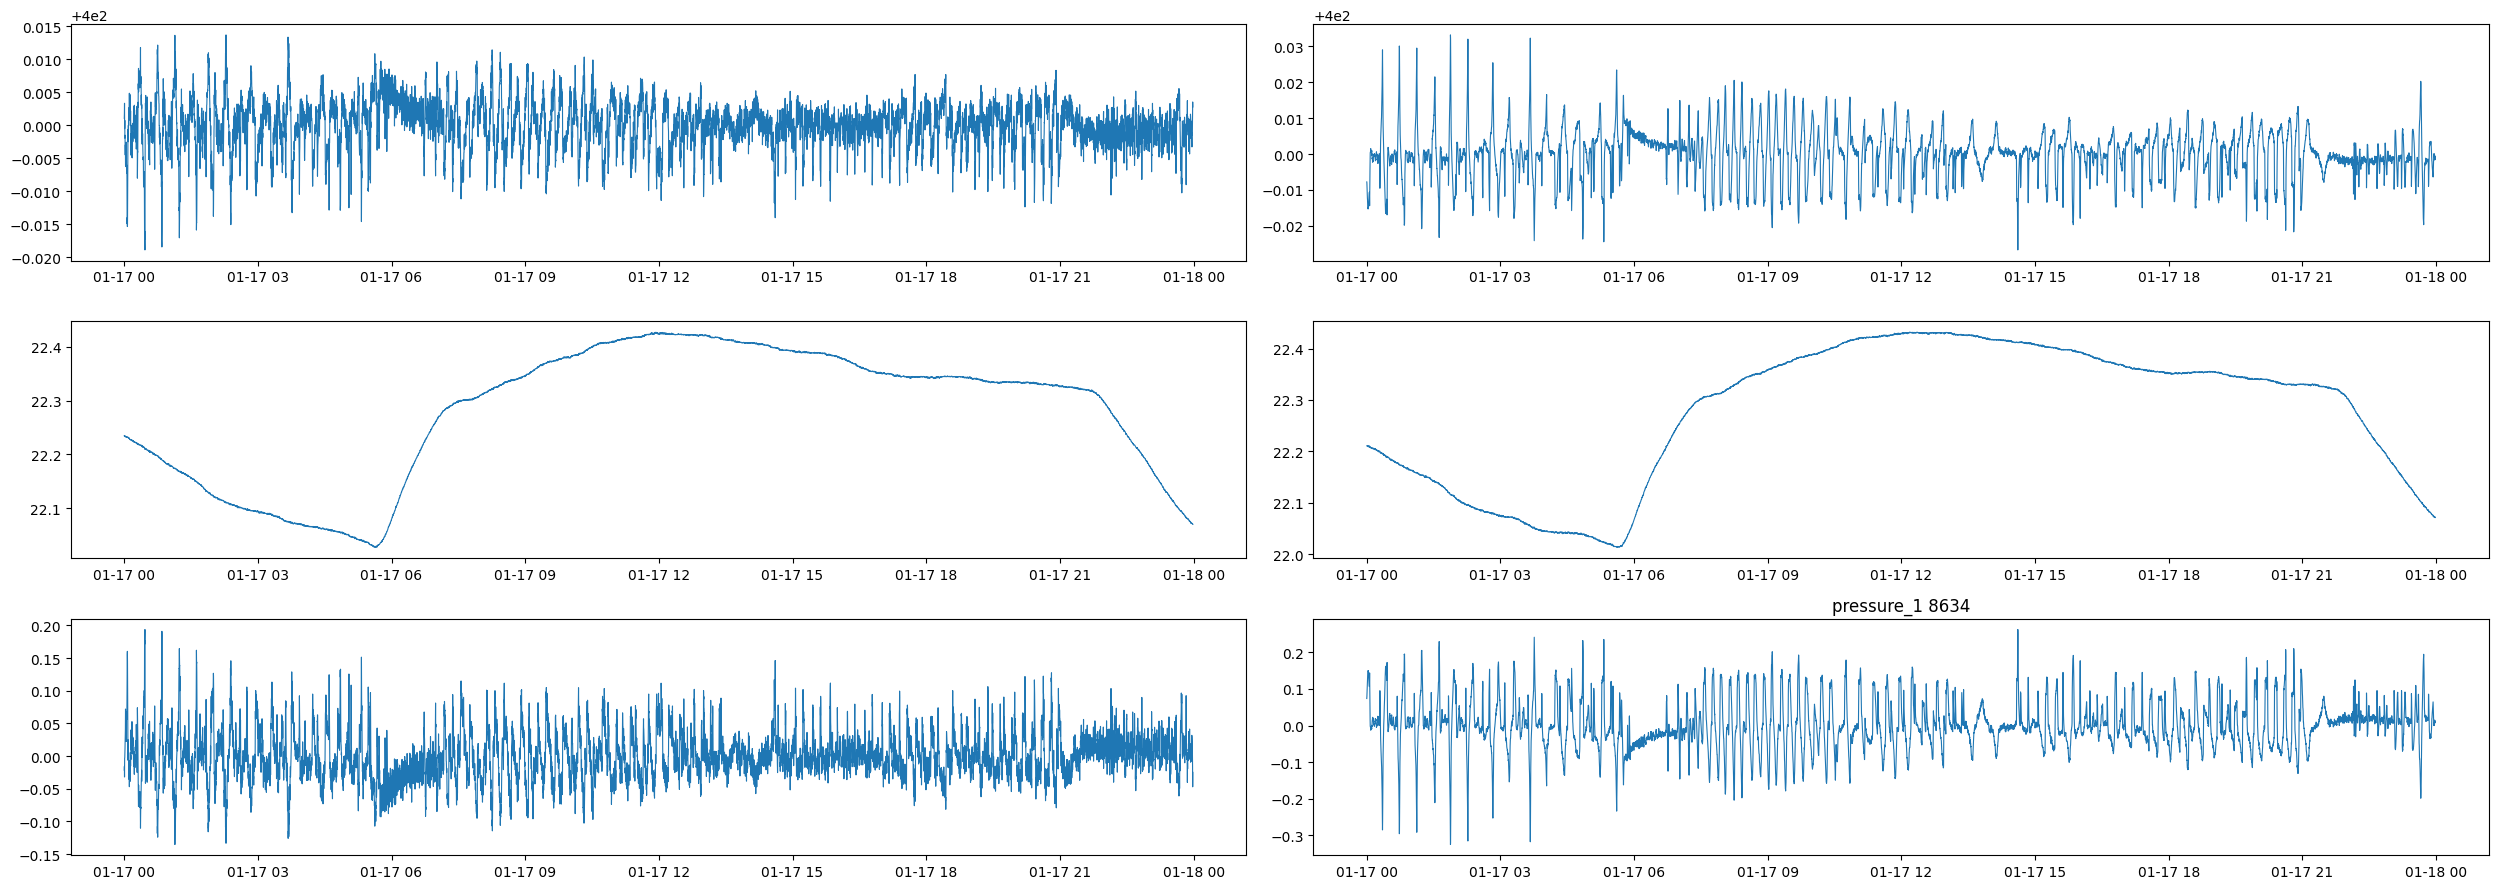

In [ ]:
nrows, ncols = 3, 2
fig, ax = plt.subplots(nrows, ncols, figsize=(25, nrows * 3))

for j,keyj in enumerate(["pressure","temperature","velocity"]):
    for i,keyi in enumerate(["1","2"]):

        ax[j,i].plot(frame["_time"], frame[f"{keyj}_{keyi}"], '-', lw=0.8)

plt.title(f"{series_name} {len(series)}")
plt.tight_layout()
plt.show()

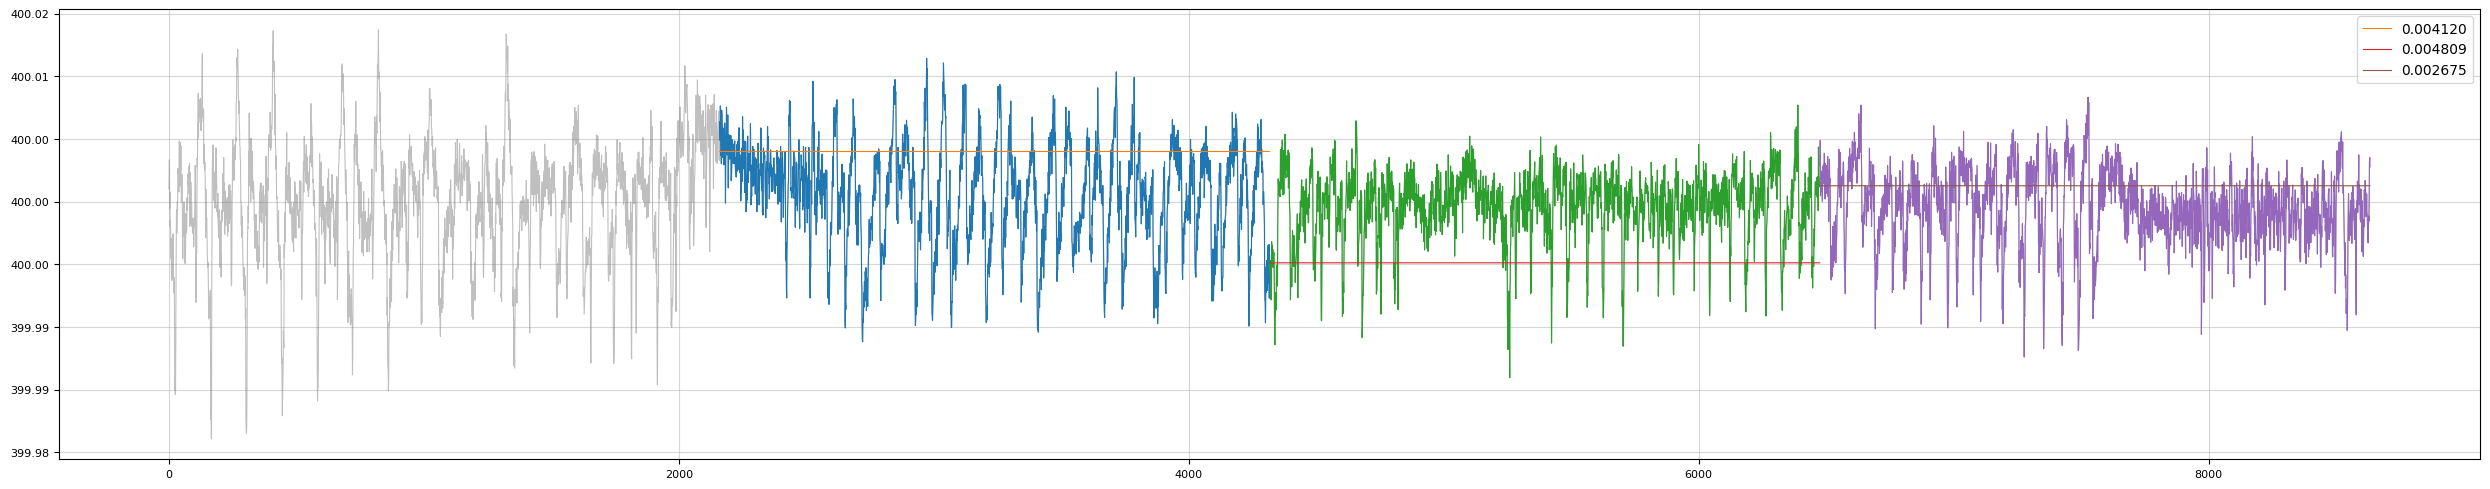

In [34]:

from sklearn.model_selection import TimeSeriesSplit

X = pd.DataFrame(range(len(series)))
y = pd.DataFrame(series.copy())

tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100))
])

n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)
scores = []

XX_test = []
yy_test, yy_pred = [], []

for train_idx, test_idx in tscv.split(X):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]    
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    scores.append(mean_absolute_error(y_test, y_pred))

    XX_test.append(X_test)
    yy_test.append(y_test)
    yy_pred.append(y_pred)

# ----------------------------------------------------------------------
 
from matplotlib.ticker import FormatStrFormatter    

nrows, ncols = 1, 1
fig, ax = plt.subplots(nrows, ncols, figsize=(25, nrows * 5))

ax.plot(X, y, '-', c='gray', lw=0.8, alpha=0.5)

for i in range(n_splits):
    ax.plot(XX_test[i], yy_test[i], '-', lw=0.8, label=f"")
    ax.plot(XX_test[i], yy_pred[i], '-', lw=0.8, label=f"{scores[i]:.6f}")

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.tick_params(direction='out', labelsize=8)
ax.grid(which='major', alpha=0.5)
ax.grid(which='minor', alpha=0.2)

plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
class TrendAnalyzer:
    """
    Komplette Trendanalyse-Pipeline
    """
    def __init__(self, series):
        self.series = series
        self.results = {}
        
    def analyze(self):
        """Führt komplette Trendanalyse durch"""
        
        # 1. Deskriptive Statistik
        self.results['descriptive'] = series.describe()
        
        # 2. Trendtests
        self.results['statistical_tests'] = statistical_trend_tests(self.series)
        
        # 3. Trend-Metriken
        self.results['trend_metrics'] = calculate_trend_metrics(self.series)
        
        # 4. STL Decomposition
        stl_result, stl_metrics = advanced_trend_decomposition(
            self.series, period=30
        )
        self.results['stl'] = stl_result
        self.results['stl_metrics'] = stl_metrics
        
        # 5. Zusammenfassung
        self.results['summary'] = self._generate_summary()
        
        return self.results
    
    def _generate_summary(self):
        """Erstellt Trend-Zusammenfassung"""
        summary = {
            'has_trend': self.results['statistical_tests'].loc['p_value', 'linear_regression'] < 0.05,
            'trend_direction': self.results['trend_metrics']['trend_class'],
            'trend_strength': self.results['trend_metrics']['trend_strength'],
            'seasonal_strength': self.results['stl_metrics']['seasonal_strength'],
            'recommended_analysis': self._get_recommendations()
        }
        return summary
    
    def _get_recommendations(self):
        """Gibt Empfehlungen basierend auf den Ergebnissen"""
        recommendations = []
        
        if self.results['trend_metrics']['trend_strength'] > 0.7:
            recommendations.append("Starker Trend vorhanden - Trend-basierte Modelle geeignet")
        
        if self.results['stl_metrics']['seasonal_strength'] > 0.3:
            recommendations.append("Starke Saisonalität - Saisonbereinigung empfohlen")
        
        if self.results['trend_metrics']['std_daily_change'] > self.results['trend_metrics']['avg_daily_change']:
            recommendations.append("Hohe Volatilität - Robuste Methoden verwenden")
        
        return recommendations
    
    def report(self):
        """Erstellt einen detaillierten Report"""
        print("=" * 60)
        print("TRENDANALYSE REPORT")
        print("=" * 60)
        print(f"\n1. DATENÜBERSICHT:")
        print(f"   Datenpunkte: {len(self.series)}")
        
        print(f"\n2. TREND ERKENNUNG:")
        trend_class = self.results['trend_metrics']['trend_class']
        p_value = self.results['statistical_tests'].loc['p_value', 'linear_regression']
        print(f"   Trendrichtung: {trend_class}")
        print(f"   Statistische Signifikanz: {'Signifikant' if p_value < 0.05 else 'Nicht signifikant'}")
        print(f"   Trendstärke: {self.results['trend_metrics']['trend_strength']:.1%}")
        
        print(f"\n3. EMPFEHLUNGEN:")
        for rec in self.results['summary']['recommended_analysis']:
            print(f"   • {rec}")
        print("=" * 60)

# Komplette Analyse durchführen
analyzer = TrendAnalyzer(series)
results = analyzer.analyze()
analyzer.report()